# Project 3. E.coli outbreak investigation. De novo assembly and annotation of bacterial genomes.

Lab notebook by Nikita Vyatkin

This week, you will follow in the footsteps of the bioinformaticians investigating the outbreak by assembling the genome of the deadly E. coli X strain. Specifically, we will provide you with Illumina reads from the TY2482 sample, which were generated at Beijing Genome Institute and deposited into the Short Read Archive (http://www.ncbi.nlm.nih.gov/sra) for public access. After we have assembled the E. coli X genome, we will determine which other strain(s) it is most similar to in an effort to determine how it could have arisen. In particular, once we know where it came from, we can ask what new genes it possesses for pathogenicity, and how it evolved these new functions.

Our workflow will be to answer the following questions:
1. What is the genome sequence of E. coli X?
2. What strain of E. coli is E. coli X most similar to? (Where did it come from?)
3. What are the genes that E. coli X contains?
4. Which of these genes make E. coli X distinct?
5. How did E. coli X evolve to obtain these genes?
6. How did E. coli X become pathogenic?





## Assembling the Genome

DNA sequencing technology cannot read whole genomes in one go, so we will assemble genome from the short reads generated by the Illumina instrument. We will use the [SPAdes](https://cab.spbu.ru/software/spades/) assembler (Bankevich et al., 2012) to assemble the E. coli X genome from reads into contigs.

A contig is a “contiguous” segment of the genome that has been reconstructed by an assembly algorithm. In addition to contigs, SPAdes uses information about the distances between reads within read-pairs (called insert size) to combine contigs into ordered collections of adjacent contigs called scaffolds.Genome assembly programs often fill a gap in a scaffold of length m by a sequence of m occurrences of “N” (a placeholder for unknown nucleotides).

In modern DNA sequencing projects, DNA fragments are sequenced from both the 5' and 3' ends, giving rise to paired reads separated by some insert size. The forward and reverse read in a paired read are generated from the forward and reverse strand, respectively. A collection of paired reads is called a sequencing library; whereas most paired libraries generate reads with insert sizes below 1 kb, libraries with longer (2 kb-10 kb) insert sizes are called mate-pairs.

Many sequencing projects generate several libraries of paired reads with different insert sizes; for example, the sequencing project at the center of this task employs three libraries of insert lengths 270, 2000, and 6000 nucleotides.

The advantage of using multiple libraries is that libraries with small insert sizes are better suited for resolving short repeats, whereas libraries with larger insert sizes are better suited for resolving long repeats. For example, all bacterial genomes contain ribosomal operons, which are often repeated more than six times and are approximately 5000 nucleotides long. Thus, to resolve ribosomal operons, we need mate-pair libraries with insert sizes exceeding 5000 nt.

Once we have sequenced a genome, there are many metrics for assessing the resulting assembly. We will use QUAST (Gurevich et al., 2013), which takes many metrics into account to evaluate the overall quality of an assembly.

One of the common metrics is the N50 statistic. N50 is defined as the maximal contig length for which all contigs greater than or equal to that length comprise at least half of the sum of the lengths of all the contigs. For example, consider the five toy contigs with the following lengths: [10, 20, 30, 60, 70]. Here, the total length of contigs is 190, and contigs of length 60 and 70 account for at least 50% of the total length of contigs (60 + 70 = 130), but the contig of length 70 does not account for 50% of the total length of contigs. Thus, N50 is equal to 60.

## Dataset

For this project, we provide three libraries from the TY2482 sample with the following
insert sizes and orientation:
* SRR292678 - paired end, insert size 470 bp ([forward reads](https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R1_001.fastq.gz), [reverse reads](https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R2_001.fastq.gz), 400 Mb each)
* SRR292862 - mate pair, insert size 2 kb, ([forward reads](https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292862_S2_L001_R1_001.fastq.gz), [reverse reads](https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292862_S2_L001_R2_001.fastq.gz), 200 Mb each)
* SRR292770 - mate pair, insert size 6 kb, ([forward reads](https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292770_S1_L001_R1_001.fastq.gz), [reverse reads](https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292770_S1_L001_R2_001.fastq.gz), 200 Mb each)

In [4]:
! mkdir raw_data

In [7]:
! wget -P raw_data https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R1_001.fastq.gz https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R2_001.fastq.gz https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292862_S2_L001_R1_001.fastq.gz https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292862_S2_L001_R2_001.fastq.gz https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292770_S1_L001_R1_001.fastq.gz https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292770_S1_L001_R2_001.fastq.gz

--2022-11-21 18:03:20--  https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R1_001.fastq.gz
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 13.33.244.215, 13.33.244.96, 13.33.244.69, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|13.33.244.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 425982530 (406M) [application/x-gzip]
Saving to: ‘raw_data/SRR292678sub_S1_L001_R1_001.fastq.gz’

SRR292678sub_S1_L00 100%[===================>] 406,25M  3,62MB/s    in 2m 1s   

2022-11-21 18:05:21 (3,37 MB/s) - ‘raw_data/SRR292678sub_S1_L001_R1_001.fastq.gz’ saved [425982530/425982530]

--2022-11-21 18:05:21--  https://d28rh4a8wq0iu5.cloudfront.net/bioinfo/SRR292678sub_S1_L001_R2_001.fastq.gz
Reusing existing connection to d28rh4a8wq0iu5.cloudfront.net:443.
HTTP request sent, awaiting response... 200 OK
Length: 426246191 (406M) [application/x-gzip]
Saving to: ‘raw_data/SRR292678sub_S1_L001_R2_001.

In [9]:
! gunzip raw_data/*

### Simple manual data analysis

In [4]:
out = ! wc -l raw_data/*.fastq

out = [s.split() for s in out]

for item in out:
    print(f"Number of reads in {item[1]}: {int(item[0]) // 4:,}")

Number of reads in raw_data/SRR292678sub_S1_L001_R1_001.fastq: 5,499,346
Number of reads in raw_data/SRR292678sub_S1_L001_R2_001.fastq: 5,499,346
Number of reads in raw_data/SRR292770_S1_L001_R1_001.fastq: 5,102,041
Number of reads in raw_data/SRR292770_S1_L001_R2_001.fastq: 5,102,041
Number of reads in raw_data/SRR292862_S2_L001_R1_001.fastq: 5,102,041
Number of reads in raw_data/SRR292862_S2_L001_R2_001.fastq: 5,102,041
Number of reads in total: 31,406,856


In [12]:
! mkdir fastqc_reports

In [19]:
! fastqc -q -t 6 -o fastqc_reports/ raw_data/*

## K-mer profile and genome size estimation

For our purposes it’s OK to only analyze the paired-end library (SRR292678). To count kmers, we can use the Jellyfish - fast kmer counting program that will count the frequency of all possible k-mers of a given length in our data (available with apt-get).

In [11]:
! jellyfish count --help

Usage: jellyfish count [options] file:path+

Count k-mers in fasta or fastq files

Options (default value in (), *required):
 -m, --mer-len=uint32                    *Length of mer
 -s, --size=uint64                       *Initial hash size
 -t, --threads=uint32                     Number of threads (1)
     --sam=PATH                           SAM/BAM/CRAM formatted input file
 -F, --Files=uint32                       Number files open simultaneously (1)
 -g, --generator=path                     File of commands generating fast[aq]
 -G, --Generators=uint32                  Number of generators run simultaneously (1)
 -S, --shell=string                       Shell used to run generator commands ($SHELL or /bin/sh)
 -o, --output=string                      Output file (mer_counts.jf)
 -c, --counter-len=Length in bits         Length bits of counting field (7)
     --out-counter-len=Length in bytes    Length in bytes of counter field in output (4)
 -C, --canonical                         

In [12]:
! mkdir jellyfish_analysis

In [1]:
! jellyfish count -t 10 -C -s 50000000 -m 31 -o jellyfish_analysis/kmer_counts_31.jf raw_data/SRR292678sub_S1_L001_R?_001.fastq

In [117]:
! jellyfish histo --help

Usage: jellyfish histo [options] db:path

Create an histogram of k-mer occurrences

Create an histogram with the number of k-mers having a given
count. In bucket 'i' are tallied the k-mers which have a count 'c'
satisfying 'low+i*inc <= c < low+(i+1)*inc'. Buckets in the output are
labeled by the low end point (low+i*inc).

The last bucket in the output behaves as a catchall: it tallies all
k-mers with a count greater or equal to the low end point of this
bucket.

Options (default value in (), *required):
 -l, --low=uint64                         Low count value of histogram (1)
 -h, --high=uint64                        High count value of histogram (10000)
 -i, --increment=uint64                   Increment value for buckets (1)
 -t, --threads=uint32                     Number of threads (1)
 -f, --full                               Full histo. Don't skip count 0. (false)
 -o, --output=string                      Output file
 -v, --verbose                            Output information

In [2]:
! jellyfish histo -t 10 -o jellyfish_analysis/plot_31.csv jellyfish_analysis/kmer_counts_31.jf

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("jellyfish_analysis/plot_31.csv", sep=' ', names=["occur_num", "num_31-mers"])
# df.index = df["occur_num"]
# df.drop(columns=["occur_num"], inplace=True)

df

,occur_num,num_31-mers
0,1,13894353
1,2,822668
2,3,154910
3,4,53078
4,5,26464
...,...,...
1564,2101,1
1565,2114,1
1566,2224,1
1567,2232,1


In [4]:
df["log_num_31-mers"] = np.log(df["num_31-mers"]) 

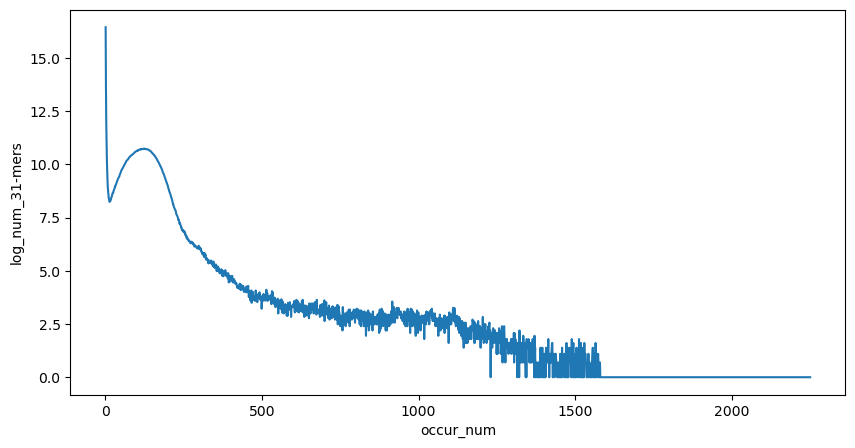

In [5]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="occur_num", y="log_num_31-mers")

plt.show()

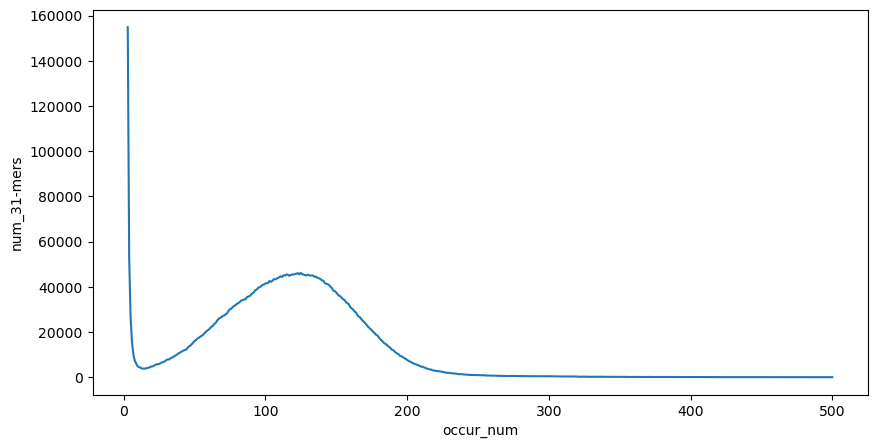

In [14]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df.iloc[2:500], x="occur_num", y="num_31-mers")

plt.ylabel("num_31-mers")
plt.show()

First, we should determine the border between the peak corresponding to single copy region and the initial peak corresponding to sequence errors.

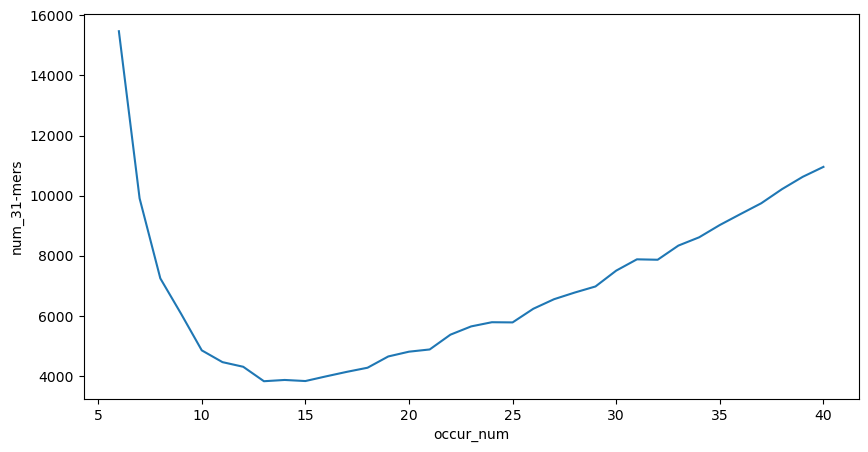

In [22]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df.iloc[5:40], x="occur_num", y="num_31-mers")

plt.ylabel("num_31-mers")
plt.show()

In [25]:
df.iloc[11:]

,occur_num,num_31-mers,log_num_31-mers
11,12,4308,8.368229
12,13,3827,8.249836
13,14,3869,8.260751
14,15,3833,8.251403
15,16,3989,8.291296
...,...,...,...
1564,2101,1,0.000000
1565,2114,1,0.000000
1566,2224,1,0.000000
1567,2232,1,0.000000


Now, we would calculate the total number of k-mer in the distribution

In [26]:
np.sum(df.loc[14:, "occur_num"] * df.loc[14:, "num_31-mers"])

643044370

Next, we want to know the peak position.

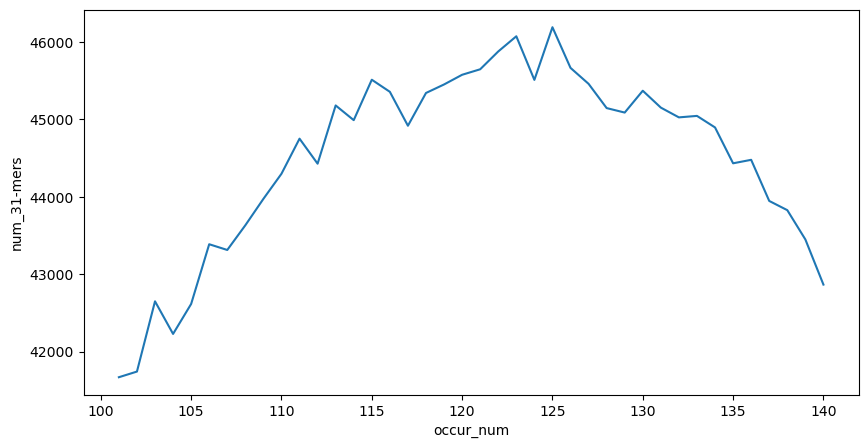

In [27]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df.iloc[100:140], x="occur_num", y="num_31-mers")

plt.ylabel("num_31-mers")
plt.show()

The peak is at 125

In [29]:
genome_length_estimate = np.sum(df.loc[14:, "occur_num"] * df.loc[14:, "num_31-mers"]) / 125
genome_length_estimate

5144354.96

If we regard single copy region as frequency between 14 and 200, the size of single copy region can be roughly calculated as 

In [30]:
single_copy_region_length_estimate = np.sum(df.loc[14:200, "occur_num"] * df.loc[14:200, "num_31-mers"]) / 125
single_copy_region_length_estimate

4660331.44

In [31]:
single_copy_region_length_estimate / genome_length_estimate

0.90591171803588

## Assembling E. coli X genome from paired reads

In [5]:
! spades.py

SPAdes genome assembler v3.13.0

Usage: /home/nikitos/Programs/anaconda3/envs/bio_py39/bin/spades.py [options] -o <output_dir>

Basic options:
-o	<output_dir>	directory to store all the resulting files (required)
--sc			this flag is required for MDA (single-cell) data
--meta			this flag is required for metagenomic sample data
--rna			this flag is required for RNA-Seq data 
--plasmid		runs plasmidSPAdes pipeline for plasmid detection 
--iontorrent		this flag is required for IonTorrent data
--test			runs SPAdes on toy dataset
-h/--help		prints this usage message
-v/--version		prints version

Input data:
--12	<filename>	file with interlaced forward and reverse paired-end reads
-1	<filename>	file with forward paired-end reads
-2	<filename>	file with reverse paired-end reads
-s	<filename>	file with unpaired reads
--merged	<filename>	file with merged forward and reverse paired-end reads
--pe<#>-12	<filename>	file with interlaced reads for paired-end library number <#> (<#> = 1,2,...,9)
--pe<

In [7]:
! spades.py --pe1-1 raw_data/SRR292678sub_S1_L001_R1_001.fastq --pe1-2 raw_data/SRR292678sub_S1_L001_R2_001.fastq -o spades_output/pe_only

Command line: /home/nikitos/Programs/anaconda3/envs/bio_py39/bin/spades.py	--pe1-1	/home/nikitos/Study/BI/Workshop on bioinformatics/Project3/raw_data/SRR292678sub_S1_L001_R1_001.fastq	--pe1-2	/home/nikitos/Study/BI/Workshop on bioinformatics/Project3/raw_data/SRR292678sub_S1_L001_R2_001.fastq	-o	/home/nikitos/Study/BI/Workshop on bioinformatics/Project3/spades_output/pe_only	

System information:
  SPAdes version: 3.13.0
  Python version: 3.9.15
  OS: Linux-5.15.0-53-generic-x86_64-with-glibc2.31

Output dir: /home/nikitos/Study/BI/Workshop on bioinformatics/Project3/spades_output/pe_only
Mode: read error correction and assembling
Debug mode is turned OFF

Dataset parameters:
  Multi-cell mode (you should set '--sc' flag if input data was obtained with MDA (single-cell) technology or --meta flag if processing metagenomic dataset)
  Reads:
    Library number: 1, library type: paired-end
      orientation: fr
      left reads: ['/home/nikitos/Study/BI/Workshop on bioinformatics/Project3

  0:02:52.755     1G / 5G    INFO    General                 (main.cpp                  : 218)   Solid k-mers iteration 0 produced 53046 new k-mers.
  0:03:19.340     1G / 5G    INFO    General                 (main.cpp                  : 218)   Solid k-mers iteration 1 produced 1043 new k-mers.
  0:03:46.057     1G / 5G    INFO    General                 (main.cpp                  : 218)   Solid k-mers iteration 2 produced 30 new k-mers.
  0:04:11.850     1G / 5G    INFO    General                 (main.cpp                  : 218)   Solid k-mers iteration 3 produced 0 new k-mers.
  0:04:11.850     1G / 5G    INFO    General                 (main.cpp                  : 222)   Solid k-mers finalized
  0:04:11.850     1G / 5G    INFO    General                 (hammer_tools.cpp          : 220)   Starting read correction in 12 threads.
  0:04:11.850     1G / 5G    INFO    General                 (hammer_tools.cpp          : 233)   Correcting pair of reads: /home/nikitos/Study/BI/Workshop 

  0:00:46.935     5G / 5G    INFO    General                 (kmer_splitters.hpp        : 289)   Processed 19141252 reads
  0:00:48.400     5G / 5G    INFO    General                 (kmer_splitters.hpp        : 289)   Processed 21996454 reads
  0:00:48.400     5G / 5G    INFO    General                 (kmer_splitters.hpp        : 295)   Adding contigs from previous K
  0:00:48.626    48M / 5G    INFO    General                 (kmer_splitters.hpp        : 308)   Used 21996454 reads
  0:00:48.626    48M / 5G    INFO    General                 (kmer_index_builder.hpp    : 120)   Starting k-mer counting.
  0:00:48.718    48M / 5G    INFO    General                 (kmer_index_builder.hpp    : 127)   K-mer counting done. There are 6272563 kmers in total.
  0:00:48.718    48M / 5G    INFO    General                 (kmer_index_builder.hpp    : 133)   Merging temporary buckets.
  0:00:48.746    48M / 5G    INFO    General                 (stage.cpp                 : 101)   PROCEDURE == Ext

  0:01:06.585    52M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Initial ec remover triggered 4114 times
  0:01:06.585    52M / 5G    INFO   Simplification           (parallel_processing.hpp   : 165)   Running Initial isolated edge remover
  0:01:06.599    52M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Initial isolated edge remover triggered 7842 times
  0:01:06.599    52M / 5G    INFO   StageManager             (stage.cpp                 : 132)   STAGE == Simplification
  0:01:06.599    52M / 5G    INFO    General                 (simplification.cpp        : 357)   Graph simplification started
  0:01:06.599    52M / 5G    INFO    General                 (graph_simplification.hpp  : 634)   Creating parallel br instance
  0:01:06.599    52M / 5G    INFO    General                 (simplification.cpp        : 362)   PROCEDURE == Simplification cycle, iteration 1
  0:01:06.599    52M / 5G    INFO   Simplification           (

  0:01:06.746    52M / 5G    INFO    General                 (contig_output.hpp         :  22)   Outputting contigs to /home/nikitos/Study/BI/Workshop on bioinformatics/Project3/spades_output/pe_only//K21/before_rr.fasta
  0:01:06.788    52M / 5G    INFO    General                 (contig_output_stage.cpp   :  51)   Outputting FastG graph to /home/nikitos/Study/BI/Workshop on bioinformatics/Project3/spades_output/pe_only//K21/assembly_graph.fastg
  0:01:06.939    52M / 5G    INFO    General                 (contig_output.hpp         :  22)   Outputting contigs to /home/nikitos/Study/BI/Workshop on bioinformatics/Project3/spades_output/pe_only//K21/simplified_contigs.fasta
  0:01:06.980    52M / 5G    INFO    General                 (contig_output.hpp         :  22)   Outputting contigs to /home/nikitos/Study/BI/Workshop on bioinformatics/Project3/spades_output/pe_only//K21/final_contigs.fasta
  0:01:07.022    52M / 5G    INFO   StageManager             (stage.cpp                 : 132)

  0:00:12.953    56M / 5G    INFO   Early tip clipping       (early_simplification.hpp  : 184)   366647 34-mers were removed by early tip clipper
  0:00:12.953    56M / 5G    INFO    General                 (stage.cpp                 : 101)   PROCEDURE == Condensing graph
  0:00:12.953    56M / 5G    INFO   UnbranchingPathExtractor (debruijn_graph_constructor: 355)   Extracting unbranching paths
  0:00:13.226    56M / 5G    INFO   UnbranchingPathExtractor (debruijn_graph_constructor: 374)   Extracting unbranching paths finished. 22195 sequences extracted
  0:00:13.385    56M / 5G    INFO   UnbranchingPathExtractor (debruijn_graph_constructor: 310)   Collecting perfect loops
  0:00:13.444    56M / 5G    INFO   UnbranchingPathExtractor (debruijn_graph_constructor: 343)   Collecting perfect loops finished. 3 loops collected
  0:00:13.456    56M / 5G    INFO    General                 (stage.cpp                 : 101)   PROCEDURE == Filling coverage indices (PHM)
  0:00:13.456    56M / 5G 

  0:00:28.192    52M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Removing isolated edges triggered 160 times
  0:00:28.193    52M / 5G    INFO    General                 (simplification.cpp        : 470)   Counting average coverage
  0:00:28.193    52M / 5G    INFO    General                 (simplification.cpp        : 476)   Average coverage = 119.293
  0:00:28.193    52M / 5G    INFO   StageManager             (stage.cpp                 : 132)   STAGE == Contig Output
  0:00:28.193    52M / 5G    INFO    General                 (contig_output_stage.cpp   :  40)   Writing GFA to /home/nikitos/Study/BI/Workshop on bioinformatics/Project3/spades_output/pe_only//K33/assembly_graph_with_scaffolds.gfa
  0:00:28.229    52M / 5G    INFO    General                 (contig_output.hpp         :  22)   Outputting contigs to /home/nikitos/Study/BI/Workshop on bioinformatics/Project3/spades_output/pe_only//K33/before_rr.fasta
  0:00:28.268    52M / 5G    INFO    Ge

  0:00:08.506    48M / 5G    INFO   K-mer Index Building     (kmer_index_builder.hpp    : 314)   Building perfect hash indices
  0:00:08.666    48M / 5G    INFO    General                 (kmer_index_builder.hpp    : 150)   Merging final buckets.
  0:00:08.781    48M / 5G    INFO   K-mer Index Building     (kmer_index_builder.hpp    : 336)   Index built. Total 2840440 bytes occupied (3.72045 bits per kmer).
  0:00:08.783    56M / 5G    INFO   DeBruijnExtensionIndexBu (kmer_extension_index_build:  99)   Building k-mer extensions from k+1-mers
  0:00:08.968    56M / 5G    INFO   DeBruijnExtensionIndexBu (kmer_extension_index_build: 103)   Building k-mer extensions from k+1-mers finished.
  0:00:08.969    56M / 5G    INFO    General                 (stage.cpp                 : 101)   PROCEDURE == Condensing graph
  0:00:09.013    56M / 5G    INFO   UnbranchingPathExtractor (debruijn_graph_constructor: 355)   Extracting unbranching paths
  0:00:09.329    64M / 5G    INFO   UnbranchingPathE

  0:00:23.211    60M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Initial tip clipper triggered 66988 times
  0:00:23.211    60M / 5G    INFO   Simplification           (parallel_processing.hpp   : 165)   Running Initial ec remover
  0:00:23.217    60M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Initial ec remover triggered 168 times
  0:00:23.217    60M / 5G    INFO   Simplification           (parallel_processing.hpp   : 165)   Running Initial isolated edge remover
  0:00:23.243    60M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Initial isolated edge remover triggered 9944 times
  0:00:23.244    60M / 5G    INFO   StageManager             (stage.cpp                 : 132)   STAGE == Simplification
  0:00:23.244    60M / 5G    INFO    General                 (simplification.cpp        : 357)   Graph simplification started
  0:00:23.244    60M / 5G    INFO    General                 (graph_sim

  0:00:23.499     5G / 5G    INFO    General                 (edge_index_builders.hpp   :  77)   Processed 2419 edges
  0:00:23.499     5G / 5G    INFO    General                 (edge_index_builders.hpp   :  82)   Used 2419 sequences.
  0:00:23.531    60M / 5G    INFO    General                 (kmer_index_builder.hpp    : 120)   Starting k-mer counting.
  0:00:23.573    60M / 5G    INFO    General                 (kmer_index_builder.hpp    : 127)   K-mer counting done. There are 5284628 kmers in total.
  0:00:23.574    60M / 5G    INFO    General                 (kmer_index_builder.hpp    : 133)   Merging temporary buckets.
  0:00:23.617    60M / 5G    INFO   K-mer Index Building     (kmer_index_builder.hpp    : 314)   Building perfect hash indices
  0:00:23.718    60M / 5G    INFO    General                 (kmer_index_builder.hpp    : 150)   Merging final buckets.
  0:00:23.820    60M / 5G    INFO   K-mer Index Building     (kmer_index_builder.hpp    : 336)   Index built. Total 245

  0:00:37.023   392M / 5G    INFO    General                 (sequence_mapper_notifier.h:  80)   Processed 4200000 reads
  0:00:37.639   392M / 5G    INFO    General                 (sequence_mapper_notifier.h:  98)   Total 5498906 reads processed
  0:00:38.299   392M / 5G    INFO    General                 (pair_info_count.cpp       : 209)   Edge pairs: 67108864 (rough upper limit)
  0:00:38.299   392M / 5G    INFO    General                 (pair_info_count.cpp       : 213)   2636627 paired reads (47.9482% of all) aligned to long edges
  0:00:38.309   184M / 5G    INFO    General                 (pair_info_count.cpp       : 354)     Insert size = 469.025, deviation = 14.6939, left quantile = 450, right quantile = 486, read length = 90
  0:00:38.354   376M / 5G    INFO    General                 (pair_info_count.cpp       : 371)   Filtering data for library #0
  0:00:38.354   376M / 5G    INFO    General                 (pair_info_count.cpp       :  39)   Selecting usual mapper
  0:00

  0:00:44.683   188M / 5G    INFO    General                 (contig_output.hpp         :  22)   Outputting contigs to /home/nikitos/Study/BI/Workshop on bioinformatics/Project3/spades_output/pe_only//K55/before_rr.fasta
  0:00:44.737   188M / 5G    INFO    General                 (contig_output_stage.cpp   :  51)   Outputting FastG graph to /home/nikitos/Study/BI/Workshop on bioinformatics/Project3/spades_output/pe_only//K55/assembly_graph.fastg
  0:00:44.898   188M / 5G    INFO    General                 (contig_output_stage.cpp   :  20)   Outputting FastG paths to /home/nikitos/Study/BI/Workshop on bioinformatics/Project3/spades_output/pe_only//K55/final_contigs.paths
  0:00:44.961   188M / 5G    INFO    General                 (contig_output_stage.cpp   :  20)   Outputting FastG paths to /home/nikitos/Study/BI/Workshop on bioinformatics/Project3/spades_output/pe_only//K55/scaffolds.paths
  0:00:45.023   188M / 5G    INFO    General                 (launch.hpp                : 149) 

In [1]:
! quast.py

QUAST: Quality Assessment Tool for Genome Assemblies
Version: 5.2.0

Usage: python /home/nikitos/Programs/anaconda3/envs/bio_py39/bin/quast.py [options] <files_with_contigs>

Options:
-o  --output-dir  <dirname>       Directory to store all result files [default: quast_results/results_<datetime>]
-r                <filename>      Reference genome file
-g  --features [type:]<filename>  File with genomic feature coordinates in the reference (GFF, BED, NCBI or TXT)
                                  Optional 'type' can be specified for extracting only a specific feature type from GFF
-m  --min-contig  <int>           Lower threshold for contig length [default: 500]
-t  --threads     <int>           Maximum number of threads [default: 25% of CPUs]

These are basic options. To see the full list, use --help

Online QUAST manual is available at http://quast.sf.net/manual


In [3]:
! quast.py -o quast_results/pe_only spades_output/pe_only/contigs.fasta spades_output/pe_only/scaffolds.fasta

/home/nikitos/Programs/anaconda3/envs/bio_py39/bin/quast.py -o quast_results/pe_only spades_output/pe_only/contigs.fasta spades_output/pe_only/scaffolds.fasta

Version: 5.2.0

System information:
  OS: Linux-5.15.0-53-generic-x86_64-with-glibc2.31 (linux_64)
  Python version: 3.9.15
  CPUs number: 12

Started: 2022-11-25 14:41:10

Logging to /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/quast_results/pe_only/quast.log
NOTICE: Maximum number of threads is set to 3 (use --threads option to set it manually)

CWD: /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3
Main parameters: 
  MODE: default, threads: 3, min contig length: 500, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Contigs:
  Pre-processing...
  1  spades_output/pe_only/contigs.fasta ==> contigs
  2  spades_output/pe_only/scaffolds.fasta ==> scaffolds

2022-11-25 14:41:11
Running Basic statistics processor.

### Effect of read correction.

In [33]:
! jellyfish count -t 10 -C -s 50000000 -m 31 -o jellyfish_analysis/corrected_kmer_counts_31.jf spades_output/pe_only/corrected/SRR292678sub_S1_L001_R?_001.00.0_0.cor.fastq

In [34]:
! jellyfish histo -t 10 -o jellyfish_analysis/corrected_plot_31.csv jellyfish_analysis/corrected_kmer_counts_31.jf

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("jellyfish_analysis/plot_31.csv", sep=' ', names=["occur_num", "num_31-mers"])
df_corrected = pd.read_csv("jellyfish_analysis/corrected_plot_31.csv", sep=' ', names=["occur_num", "num_31-mers"])

df_corrected

,occur_num,num_31-mers
0,1,905758
1,2,26076
2,3,6855
3,4,3952
4,5,3524
...,...,...
1588,2140,1
1589,2154,1
1590,2258,1
1591,2265,1


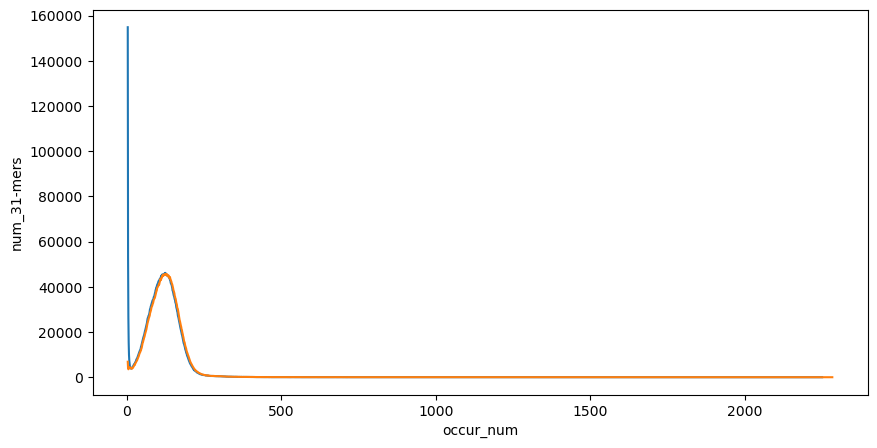

In [42]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df.loc[2:], x="occur_num", y="num_31-mers")
sns.lineplot(data=df_corrected.loc[2:], x="occur_num", y="num_31-mers")

plt.ylabel("num_31-mers")
plt.show()

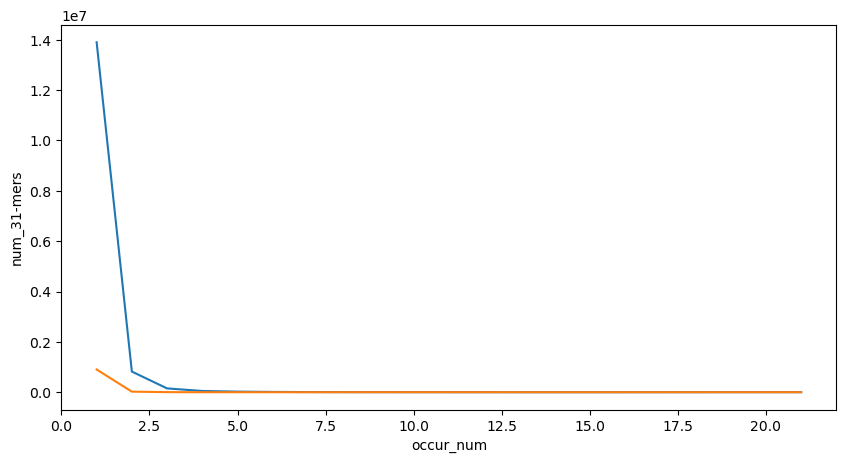

In [44]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df.loc[:20], x="occur_num", y="num_31-mers")
sns.lineplot(data=df_corrected.loc[:20], x="occur_num", y="num_31-mers")

plt.ylabel("num_31-mers")
plt.show()

## Impact of reads with large insert size

In [1]:
! spades.py --pe1-1 raw_data/SRR292678sub_S1_L001_R1_001.fastq --pe1-2 raw_data/SRR292678sub_S1_L001_R2_001.fastq --mp1-1 raw_data/SRR292770_S1_L001_R1_001.fastq --mp1-2 raw_data/SRR292770_S1_L001_R2_001.fastq --mp2-1 raw_data/SRR292862_S2_L001_R1_001.fastq --mp2-2 raw_data/SRR292862_S2_L001_R2_001.fastq -o spades_output/three_libs

Command line: /home/nikitos/Programs/anaconda3/envs/bio_py39/bin/spades.py	--pe1-1	/home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/raw_data/SRR292678sub_S1_L001_R1_001.fastq	--pe1-2	/home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/raw_data/SRR292678sub_S1_L001_R2_001.fastq	--mp1-1	/home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/raw_data/SRR292770_S1_L001_R1_001.fastq	--mp1-2	/home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/raw_data/SRR292770_S1_L001_R2_001.fastq	--mp2-1	/home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/raw_data/SRR292862_S2_L001_R1_001.fastq	--mp2-2	/home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/raw_data/SRR292862_S2_L001_R2_001.fastq	-o	/home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/spades_output/three_libs	

System information:
  SPAdes version: 3.13.0
  Python version: 3.9.15
  OS: Linux-5.15.0-53-generic-x86_64-with-glibc2.31

Output dir: /home/nikitos/Study/BI/Workshop_on_bioinformatics/Pro

  0:01:00.610    48M / 5G    INFO   K-mer Index Building     (kmer_index_builder.hpp    : 314)   Building perfect hash indices
  0:01:07.078   120M / 5G    INFO    General                 (kmer_index_builder.hpp    : 150)   Merging final buckets.
  0:01:08.389   120M / 5G    INFO   K-mer Index Building     (kmer_index_builder.hpp    : 336)   Index built. Total 78648912 bytes occupied (3.71003 bits per kmer).
  0:01:08.389   120M / 5G    INFO   K-mer Counting           (kmer_data.cpp             : 356)   Arranging kmers in hash map order
  0:01:14.281     2G / 5G    INFO    General                 (main.cpp                  : 148)   Clustering Hamming graph.
  0:05:07.475     2G / 5G    INFO    General                 (main.cpp                  : 155)   Extracting clusters
  0:05:31.962     2G / 8G    INFO    General                 (main.cpp                  : 167)   Clustering done. Total clusters: 112762733
  0:05:32.025     1G / 8G    INFO   K-mer Counting           (kmer_data.cpp  

  0:15:34.924     6G / 8G    INFO    General                 (hammer_tools.cpp          : 185)   Written batch 0
  0:15:36.265     6G / 8G    INFO    General                 (hammer_tools.cpp          : 168)   Prepared batch 1 of 1200000 reads.
  0:15:40.046     6G / 8G    INFO    General                 (hammer_tools.cpp          : 175)   Processed batch 1
  0:15:40.808     6G / 8G    INFO    General                 (hammer_tools.cpp          : 185)   Written batch 1
  0:15:42.208     6G / 8G    INFO    General                 (hammer_tools.cpp          : 168)   Prepared batch 2 of 1200000 reads.
  0:15:45.900     6G / 8G    INFO    General                 (hammer_tools.cpp          : 175)   Processed batch 2
  0:15:46.643     6G / 8G    INFO    General                 (hammer_tools.cpp          : 185)   Written batch 2
  0:15:48.050     6G / 8G    INFO    General                 (hammer_tools.cpp          : 168)   Prepared batch 3 of 1200000 reads.
  0:15:51.754     6G / 8G    INFO  

  0:00:50.741     5G / 5G    INFO    General                 (kmer_splitters.hpp        : 289)   Processed 19140037 reads
  0:00:52.382     5G / 5G    INFO    General                 (kmer_splitters.hpp        : 289)   Processed 21996480 reads
  0:00:52.382     5G / 5G    INFO    General                 (kmer_splitters.hpp        : 295)   Adding contigs from previous K
  0:00:52.692    48M / 5G    INFO    General                 (kmer_splitters.hpp        : 308)   Used 21996480 reads
  0:00:52.692    48M / 5G    INFO    General                 (kmer_index_builder.hpp    : 120)   Starting k-mer counting.
  0:00:52.878    48M / 5G    INFO    General                 (kmer_index_builder.hpp    : 127)   K-mer counting done. There are 7657488 kmers in total.
  0:00:52.878    48M / 5G    INFO    General                 (kmer_index_builder.hpp    : 133)   Merging temporary buckets.
  0:00:52.912    48M / 5G    INFO    General                 (stage.cpp                 : 101)   PROCEDURE == Ext

  0:01:29.565    56M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Initial tip clipper triggered 619 times
  0:01:29.565    56M / 5G    INFO   Simplification           (parallel_processing.hpp   : 165)   Running Initial ec remover
  0:01:30.084    64M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Initial ec remover triggered 42824 times
  0:01:30.084    64M / 5G    INFO   Simplification           (parallel_processing.hpp   : 165)   Running Initial isolated edge remover
  0:01:30.102    60M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Initial isolated edge remover triggered 7844 times
  0:01:30.104    56M / 5G    INFO   StageManager             (stage.cpp                 : 132)   STAGE == Simplification
  0:01:30.104    56M / 5G    INFO    General                 (simplification.cpp        : 357)   Graph simplification started
  0:01:30.104    56M / 5G    INFO    General                 (graph_sim

  0:01:30.363    56M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Removing isolated edges triggered 309 times
  0:01:30.363    56M / 5G    INFO    General                 (simplification.cpp        : 470)   Counting average coverage
  0:01:30.364    56M / 5G    INFO    General                 (simplification.cpp        : 476)   Average coverage = 145.245
  0:01:30.364    56M / 5G    INFO   StageManager             (stage.cpp                 : 132)   STAGE == Contig Output
  0:01:30.374    56M / 5G    INFO    General                 (contig_output_stage.cpp   :  40)   Writing GFA to /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/spades_output/three_libs//K21/assembly_graph_with_scaffolds.gfa
  0:01:30.411    56M / 5G    INFO    General                 (contig_output.hpp         :  22)   Outputting contigs to /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/spades_output/three_libs//K21/before_rr.fasta
  0:01:30.455    56M / 5G    INFO

  0:00:13.397    48M / 5G    INFO   K-mer Index Building     (kmer_index_builder.hpp    : 314)   Building perfect hash indices
  0:00:13.630    48M / 5G    INFO    General                 (kmer_index_builder.hpp    : 150)   Merging final buckets.
  0:00:13.782    48M / 5G    INFO   K-mer Index Building     (kmer_index_builder.hpp    : 336)   Index built. Total 3701504 bytes occupied (3.71771 bits per kmer).
  0:00:13.785    56M / 5G    INFO   DeBruijnExtensionIndexBu (kmer_extension_index_build:  99)   Building k-mer extensions from k+1-mers
  0:00:14.050    56M / 5G    INFO   DeBruijnExtensionIndexBu (kmer_extension_index_build: 103)   Building k-mer extensions from k+1-mers finished.
  0:00:14.050    56M / 5G    INFO    General                 (stage.cpp                 : 101)   PROCEDURE == Early tip clipping
  0:00:14.050    56M / 5G    INFO    General                 (construction.cpp          : 253)   Early tip clipper length bound set as (RL - K)
  0:00:14.050    56M / 5G    INF

  0:00:32.867    56M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Bulge remover triggered 93 times
  0:00:32.867    56M / 5G    INFO   Simplification           (parallel_processing.hpp   : 165)   Running Low coverage edge remover
  0:00:32.869    56M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Low coverage edge remover triggered 52 times
  0:00:32.869    56M / 5G    INFO    General                 (simplification.cpp        : 362)   PROCEDURE == Simplification cycle, iteration 3
  0:00:32.869    56M / 5G    INFO   Simplification           (parallel_processing.hpp   : 165)   Running Tip clipper
  0:00:32.869    56M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Tip clipper triggered 2 times
  0:00:32.869    56M / 5G    INFO   Simplification           (parallel_processing.hpp   : 165)   Running Bulge remover
  0:00:32.872    56M / 5G    INFO   Simplification           (parallel_processing.hpp   : 

  0:00:32.925    52M / 5G    INFO    General                 (contig_output.hpp         :  22)   Outputting contigs to /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/spades_output/three_libs//K33/before_rr.fasta
  0:00:32.965    52M / 5G    INFO    General                 (contig_output_stage.cpp   :  51)   Outputting FastG graph to /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/spades_output/three_libs//K33/assembly_graph.fastg
  0:00:33.108    52M / 5G    INFO    General                 (contig_output.hpp         :  22)   Outputting contigs to /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/spades_output/three_libs//K33/simplified_contigs.fasta
  0:00:33.147    52M / 5G    INFO    General                 (contig_output.hpp         :  22)   Outputting contigs to /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/spades_output/three_libs//K33/final_contigs.fasta
  0:00:33.187    52M / 5G    INFO   StageManager             (stage.cpp           

  0:00:09.788    56M / 5G    INFO   UnbranchingPathExtractor (debruijn_graph_constructor: 355)   Extracting unbranching paths
  0:00:10.263    68M / 5G    INFO   UnbranchingPathExtractor (debruijn_graph_constructor: 374)   Extracting unbranching paths finished. 290058 sequences extracted
  0:00:10.502    68M / 5G    INFO   UnbranchingPathExtractor (debruijn_graph_constructor: 310)   Collecting perfect loops
  0:00:10.585    68M / 5G    INFO   UnbranchingPathExtractor (debruijn_graph_constructor: 343)   Collecting perfect loops finished. 1 loops collected
  0:00:10.693   124M / 5G    INFO    General                 (stage.cpp                 : 101)   PROCEDURE == Filling coverage indices (PHM)
  0:00:10.693   124M / 5G    INFO   K-mer Index Building     (kmer_index_builder.hpp    : 301)   Building kmer index
  0:00:10.693   124M / 5G    INFO   K-mer Index Building     (kmer_index_builder.hpp    : 314)   Building perfect hash indices
  0:00:10.837   164M / 5G    INFO   K-mer Index Buildi

  0:00:26.734    68M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Bulge remover triggered 1479 times
  0:00:26.734    68M / 5G    INFO   Simplification           (parallel_processing.hpp   : 165)   Running Low coverage edge remover
  0:00:26.736    68M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Low coverage edge remover triggered 22 times
  0:00:26.736    68M / 5G    INFO    General                 (simplification.cpp        : 362)   PROCEDURE == Simplification cycle, iteration 2
  0:00:26.736    68M / 5G    INFO   Simplification           (parallel_processing.hpp   : 165)   Running Tip clipper
  0:00:26.736    68M / 5G    INFO   Simplification           (parallel_processing.hpp   : 167)   Tip clipper triggered 5 times
  0:00:26.736    68M / 5G    INFO   Simplification           (parallel_processing.hpp   : 165)   Running Bulge remover
  0:00:26.738    68M / 5G    INFO   Simplification           (parallel_processing.hpp   

  0:00:26.893     5G / 5G    INFO    General                 (edge_index_builders.hpp   :  77)   Processed 2389 edges
  0:00:26.893     5G / 5G    INFO    General                 (edge_index_builders.hpp   :  82)   Used 2389 sequences.
  0:00:26.924    64M / 5G    INFO    General                 (kmer_index_builder.hpp    : 120)   Starting k-mer counting.
  0:00:26.965    64M / 5G    INFO    General                 (kmer_index_builder.hpp    : 127)   K-mer counting done. There are 5283497 kmers in total.
  0:00:26.965    64M / 5G    INFO    General                 (kmer_index_builder.hpp    : 133)   Merging temporary buckets.
  0:00:27.008    64M / 5G    INFO   K-mer Index Building     (kmer_index_builder.hpp    : 314)   Building perfect hash indices
  0:00:27.128    68M / 5G    INFO    General                 (kmer_index_builder.hpp    : 150)   Merging final buckets.
  0:00:27.230    68M / 5G    INFO   K-mer Index Building     (kmer_index_builder.hpp    : 336)   Index built. Total 245

  0:00:43.894   972M / 5G    INFO    General                 (binary_converter.hpp      :  93)   1048576 reads processed
  0:00:48.455   972M / 5G    INFO    General                 (binary_converter.hpp      :  93)   2097152 reads processed
  0:00:57.669   972M / 5G    INFO    General                 (binary_converter.hpp      :  93)   4194304 reads processed
  0:01:02.525   728M / 5G    INFO    General                 (binary_converter.hpp      : 117)   5097081 reads written
  0:01:02.717   400M / 5G    INFO    General                 (read_converter.hpp        :  87)   Converting single reads
  0:01:02.791   544M / 5G    INFO    General                 (binary_converter.hpp      : 117)   4917 reads written
  0:01:02.798   400M / 5G    INFO    General                 (read_converter.hpp        :  95)   Converting merged reads
  0:01:02.860   544M / 5G    INFO    General                 (binary_converter.hpp      : 117)   0 reads written
  0:01:02.866   400M / 5G    INFO    General   

  0:02:33.995   208M / 5G    INFO    General                 (pair_info_count.cpp       :  30)   Mapping mate-pairs using BWA-mem mapper
  0:02:44.822   260M / 5G    INFO    General                 (sequence_mapper_notifier.h:  80)   Processed 200000 reads
  0:02:44.825   260M / 5G    INFO    General                 (sequence_mapper_notifier.h:  80)   Processed 400000 reads
  0:02:44.869   260M / 5G    INFO    General                 (sequence_mapper_notifier.h:  80)   Processed 600000 reads
  0:02:44.875   260M / 5G    INFO    General                 (sequence_mapper_notifier.h:  80)   Processed 800000 reads
  0:02:44.899   260M / 5G    INFO    General                 (sequence_mapper_notifier.h:  80)   Processed 1000000 reads
  0:02:45.009   260M / 5G    INFO    General                 (sequence_mapper_notifier.h:  80)   Processed 1200000 reads
  0:02:45.093   260M / 5G    INFO    General                 (sequence_mapper_notifier.h:  80)   Processed 2200000 reads
  0:02:55.121   260M

  0:03:07.362   244M / 5G    INFO    General                 (extenders_logic.cpp       : 152)   Creating Scaffolding 2015 extender for lib #0
  0:03:07.362   244M / 5G    INFO    General                 (extenders_logic.cpp       : 156)   Paired unclustered indices not empty, using them
  0:03:07.362   244M / 5G    INFO   ExtensionChooser2015     (extension_chooser2015.hpp :  51)   ExtensionChooser2015 created
  0:03:07.362   244M / 5G    INFO    General                 (extenders_logic.cpp       : 152)   Creating Scaffolding 2015 extender for lib #1
  0:03:07.362   244M / 5G    INFO    General                 (extenders_logic.cpp       : 156)   Paired unclustered indices not empty, using them
  0:03:07.362   244M / 5G    INFO   ExtensionChooser2015     (extension_chooser2015.hpp :  51)   ExtensionChooser2015 created
  0:03:07.362   244M / 5G    INFO    General                 (extenders_logic.cpp       : 152)   Creating Scaffolding 2015 extender for lib #0
  0:03:07.362   244M / 5G  

  0:03:09.566   240M / 5G    INFO    General                 (contig_output.hpp         :  22)   Outputting contigs to /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/spades_output/three_libs//K55/before_rr.fasta
  0:03:09.610   240M / 5G    INFO    General                 (contig_output_stage.cpp   :  51)   Outputting FastG graph to /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/spades_output/three_libs//K55/assembly_graph.fastg
  0:03:09.781   240M / 5G    INFO    General                 (contig_output_stage.cpp   :  20)   Outputting FastG paths to /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/spades_output/three_libs//K55/final_contigs.paths
  0:03:09.849   240M / 5G    INFO    General                 (contig_output_stage.cpp   :  20)   Outputting FastG paths to /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/spades_output/three_libs//K55/scaffolds.paths
  0:03:09.898   240M / 5G    INFO    General                 (launch.hpp           

In [3]:
! quast.py -o quast_reports/three_libs spades_output/three_libs/contigs.fasta spades_output/three_libs/scaffolds.fasta

/home/nikitos/Programs/anaconda3/envs/bio_py39/bin/quast.py -o quast_reports/three_libs spades_output/three_libs/contigs.fasta spades_output/three_libs/scaffolds.fasta

Version: 5.2.0

System information:
  OS: Linux-5.15.0-53-generic-x86_64-with-glibc2.31 (linux_64)
  Python version: 3.9.15
  CPUs number: 12

Started: 2022-11-25 15:57:37

Logging to /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3/quast_reports/three_libs/quast.log
NOTICE: Maximum number of threads is set to 3 (use --threads option to set it manually)

CWD: /home/nikitos/Study/BI/Workshop_on_bioinformatics/Project3
Main parameters: 
  MODE: default, threads: 3, min contig length: 500, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Contigs:
  Pre-processing...
  1  spades_output/three_libs/contigs.fasta ==> contigs
  2  spades_output/three_libs/scaffolds.fasta ==> scaffolds

2022-11-25 15:57:37
Running Basic sta

## Genome Annotation

In [1]:
! prokka

Name:
  Prokka 1.13 by Torsten Seemann <torsten.seemann@gmail.com>
Synopsis:
  rapid bacterial genome annotation
Usage:
  prokka [options] <contigs.fasta>
General:
  --help            This help
  --version         Print version and exit
  --docs            Show full manual/documentation
  --citation        Print citation for referencing Prokka
  --quiet           No screen output (default OFF)
  --debug           Debug mode: keep all temporary files (default OFF)
Setup:
  --listdb          List all configured databases
  --setupdb         Index all installed databases
  --cleandb         Remove all database indices
  --depends         List all software dependencies
Outputs:
  --outdir [X]      Output folder [auto] (default '')
  --force           Force overwriting existing output folder (default OFF)
  --prefix [X]      Filename output prefix [auto] (default '')
  --addgenes        Add 'gene' features for each 'CDS' feature (default OFF)
  --addmrna         Add 'mRNA' features for each

In [2]:
! prokka --outdir prokka_anno/ --prefix scaffolds --centre XXX spades_output/three_libs/scaffolds.fasta

[15:11:19] This is prokka 1.13
[15:11:19] Written by Torsten Seemann <torsten.seemann@gmail.com>
[15:11:19] Homepage is https://github.com/tseemann/prokka
[15:11:19] Local time is Mon Nov 28 15:11:19 2022
[15:11:19] You are nikitos
[15:11:19] Operating system is linux
[15:11:19] You have BioPerl 1.007002
[15:11:19] System has 12 cores.
[15:11:19] Will use maximum of 8 cores.
[15:11:19] Annotating as >>> Bacteria <<<
[15:11:19] Generating locus_tag from 'spades_output/three_libs/scaffolds.fasta' contents.
[15:11:19] Setting --locustag IHINPGCH from MD5 212790c1f970c236c7425b89b03e50f1
[15:11:19] Creating new output folder: prokka_anno/
[15:11:19] Running: mkdir -p prokka_anno\/
[15:11:19] Using filename prefix: scaffolds.XXX
[15:11:19] Setting HMMER_NCPU=1
[15:11:19] Writing log to: prokka_anno//scaffolds.log
[15:11:19] Command: /home/nikitos/Programs/anaconda3/envs/prokka_env/bin/prokka --outdir prokka_anno/ --prefix scaffolds --centre XXX spades_output/three_libs/scaffolds.fasta
[15:1

[15:11:24] Found 0 CRISPRs
[15:11:24] Predicting coding sequences
[15:11:24] Contigs total 5456456 bp, so using single mode
[15:11:24] Running: prodigal -i prokka_anno\/\/scaffolds\.fna -c -m -g 11 -p single -f sco -q
[15:11:28] Excluding CDS which overlaps existing RNA (rRNA) at gnl|XXX|IHINPGCH_1:793940..794194 on - strand
[15:11:28] Excluding CDS which overlaps existing RNA (rRNA) at gnl|XXX|IHINPGCH_1:835517..835771 on - strand
[15:11:28] Excluding CDS which overlaps existing RNA (tRNA) at gnl|XXX|IHINPGCH_1:1256504..1256749 on - strand
[15:11:28] Excluding CDS which overlaps existing RNA (rRNA) at gnl|XXX|IHINPGCH_1:1410968..1411222 on - strand
[15:11:28] Excluding CDS which overlaps existing RNA (tRNA) at gnl|XXX|IHINPGCH_1:1901073..1901252 on - strand
[15:11:28] Excluding CDS which overlaps existing RNA (rRNA) at gnl|XXX|IHINPGCH_2:644789..645043 on - strand
[15:11:28] Excluding CDS which overlaps existing RNA (tRNA) at gnl|XXX|IHINPGCH_2:1030821..1031042 on + strand
[15:11:28] 

[15:12:15] Modify product: Probable multidrug resistance protein EmrY => putative multidrug resistance protein EmrY
[15:12:15] Modify product: Probable multidrug resistance protein EmrK => putative multidrug resistance protein EmrK
[15:12:15] Modify product: Probable cyclic di-GMP phosphodiesterase PdeA => putative cyclic di-GMP phosphodiesterase PdeA
[15:12:15] Modify product: Probable deferrochelatase/peroxidase YfeX => putative deferrochelatase/peroxidase YfeX
[15:12:15] Modify product: Uncharacterized protein YfeY => putative protein YfeY
[15:12:15] Modify product: Uncharacterized protein Rv2575 => putative protein
[15:12:15] Modify product: Probable formate transporter 2 => putative formate transporter 2
[15:12:15] Modify product: Uncharacterized protein YfgD => putative protein YfgD
[15:12:15] Modify product: Uncharacterized protein YfgJ => putative protein YfgJ
[15:12:15] Modify product: UPF0070 protein HI_0370 => hypothetical protein
[15:12:15] Modify product: Uncharacterized l

[15:12:16] Modify product: Probable L,D-transpeptidase YbiS => putative L,D-transpeptidase YbiS
[15:12:16] Modify product: Uncharacterized ABC transporter ATP-binding protein YbiT => putative ABC transporter ATP-binding protein YbiT
[15:12:16] Modify product: Uncharacterized protein YbiU => putative protein YbiU
[15:12:16] Modify product: Probable cyclic di-GMP phosphodiesterase PdeI => putative cyclic di-GMP phosphodiesterase PdeI
[15:12:16] Modify product: Uncharacterized protein YbjN => putative protein YbjN
[15:12:16] Modify product: Uncharacterized lipoprotein YbjP => putative lipoprotein YbjP
[15:12:16] Modify product: UPF0145 protein YbjQ => hypothetical protein
[15:12:16] Modify product: Uncharacterized protein HI_0461 => putative protein
[15:12:16] Modify product: Probable hydrolase YcaC => putative hydrolase YcaC
[15:12:16] Modify product: Uncharacterized MFS-type transporter YcaD => putative MFS-type transporter YcaD
[15:12:16] Modify product: Probable formate transporter 1 

[15:12:16] Modify product: Uncharacterized oxidoreductase YdgJ => putative oxidoreductase YdgJ
[15:12:16] Modify product: Uncharacterized protein YnhF => putative protein YnhF
[15:12:16] Modify product: Uncharacterized HTH-type transcriptional regulator YahB => putative HTH-type transcriptional regulator YahB
[15:12:16] Modify product: UPF0401 protein YkfF => hypothetical protein
[15:12:16] Modify product: UPF0758 protein CT0611 => hypothetical protein
[15:12:16] Modify product: Uncharacterized protein YhcH => putative protein YhcH
[15:12:16] Modify product: Probable lipoprotein YiaD => putative lipoprotein YiaD
[15:12:16] Modify product: Uncharacterized N-acetyltransferase YjaB => putative N-acetyltransferase YjaB
[15:12:16] Modify product: Uncharacterized MFS-type transporter YhjX => putative MFS-type transporter YhjX
[15:12:16] Modify product: Probable major fimbrial subunit LpfA => putative major fimbrial subunit LpfA
[15:12:16] Modify product: Probable fimbrial chaperone LpfB => p

[15:12:17] Modify product: Uncharacterized protein YdfO => putative protein YdfO
[15:12:17] Modify product: Probable L,D-transpeptidase YcfS => putative L,D-transpeptidase YcfS
[15:12:17] Modify product: UPF0227 protein YcfP => hypothetical protein
[15:12:17] Modify product: Uncharacterized metal-dependent hydrolase YcfH => putative metal-dependent hydrolase YcfH
[15:12:17] Modify product: UPF0502 protein YceH => hypothetical protein
[15:12:17] Modify product: Uncharacterized lipoprotein YceB => putative lipoprotein YceB
[15:12:17] Modify product: Uncharacterized protein YceO => putative protein YceO
[15:12:17] Modify product: Cytochrome b561 homolog 2 => Cytochrome b561 
[15:12:17] Modify product: UPF0176 protein YceA => hypothetical protein
[15:12:17] Modify product: Probable phosphatase YcdX => putative phosphatase YcdX
[15:12:17] Modify product: Uncharacterized protein YncE => putative protein YncE
[15:12:17] Modify product: Uncharacterized protein YdcY => putative protein YdcY
[15

[15:12:24] Assigned 5121 locus_tags to CDS and RNA features.
[15:12:24] Writing outputs to prokka_anno//
[15:12:25] Generating annotation statistics file
[15:12:25] Generating Genbank and Sequin files
[15:12:25] Running: tbl2asn -V b -a r10k -l paired-ends -M n -N 1 -y 'Annotated using prokka 1.13 from https://github.com/tseemann/prokka' -Z prokka_anno\/\/scaffolds\.err -i prokka_anno\/\/scaffolds\.fsa 2> /dev/null
[15:12:35] Deleting unwanted file: prokka_anno//errorsummary.val
[15:12:35] Deleting unwanted file: prokka_anno//scaffolds.dr
[15:12:35] Deleting unwanted file: prokka_anno//scaffolds.fixedproducts
[15:12:35] Deleting unwanted file: prokka_anno//scaffolds.ecn
[15:12:35] Deleting unwanted file: prokka_anno//scaffolds.val
[15:12:35] Repairing broken .GBK output that tbl2asn produces...
[15:12:35] Running: sed 's/COORDINATES: profile/COORDINATES:profile/' < prokka_anno\/\/scaffolds\.gbf > prokka_anno\/\/scaffolds\.gbk
[15:12:35] Deleting unwanted file: prokka_anno//scaffolds.gb

In [3]:
! prokka --listdb

[15:13:10] Looking for databases in: /home/nikitos/Programs/anaconda3/envs/prokka_env/bin/../db
[15:13:10] * Kingdoms: Archaea Bacteria Mitochondria Viruses
[15:13:10] * Genera: Enterococcus Escherichia Staphylococcus
[15:13:10] * HMMs: HAMAP
[15:13:10] * CMs: Bacteria Viruses


## Finding the closest relative of E. coli X

In [2]:
! barrnap --help

Synopsis:
  barrnap 0.9 - rapid ribosomal RNA prediction
Author:
  Torsten Seemann
Usage:
  barrnap [options] chr.fa
  barrnap [options] < chr.fa
  barrnap [options] - < chr.fa
Options:
  --help            This help
  --version         Print version and exit
  --citation        Print citation for referencing barrnap
  --kingdom [X]     Kingdom: mito bac arc euk (default 'bac')
  --quiet           No screen output (default OFF)
  --threads [N]     Number of threads/cores/CPUs to use (default '1')
  --lencutoff [n.n] Proportional length threshold to label as partial (default '0.8')
  --reject [n.n]    Proportional length threshold to reject prediction (default '0.25')
  --evalue [n.n]    Similarity e-value cut-off (default '1e-06')
  --incseq          Include FASTA _input_ sequences in GFF3 output (default OFF)
  --outseq [X]      Save rRNA hit seqs to this FASTA file (default '')


In [3]:
! barrnap spades_output/three_libs/scaffolds.fasta

[barrnap] This is barrnap 0.9
[barrnap] Written by Torsten Seemann
[barrnap] Obtained from https://github.com/tseemann/barrnap
[barrnap] Detected operating system: linux
[barrnap] Adding /home/nikitos/Programs/anaconda3/envs/prokka_env/lib/barrnap/bin/../binaries/linux to end of PATH
[barrnap] Checking for dependencies:
[barrnap] Found nhmmer - /home/nikitos/Programs/anaconda3/envs/prokka_env/bin/nhmmer
[barrnap] Found bedtools - /home/nikitos/Programs/anaconda3/envs/prokka_env/bin/bedtools
[barrnap] Will use 1 threads
[barrnap] Setting evalue cutoff to 1e-06
[barrnap] Will tag genes < 0.8 of expected length.
[barrnap] Will reject genes < 0.25 of expected length.
[barrnap] Using database: /home/nikitos/Programs/anaconda3/envs/prokka_env/lib/barrnap/bin/../db/bac.hmm
[barrnap] Scanning spades_output/three_libs/scaffolds.fasta for bac rRNA genes... please wait
[barrnap] Command: nhmmer --cpu 1 -E 1e-06 --w_length 3878 -o /dev/null --tblout /dev/stdout '/home/nikitos/Programs/anaconda3/en